# Summary
This tutorial demonstrates how to train a convolutional neural network on the MNIST character recognition problem. 

In [1]:
import sys
import os
import pickle
import numpy
import theano
import pylearn2
import pylearn2.datasets
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.models.mlp as mlp
import pylearn2.train
import pylearn2.termination_criteria
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: Tesla C2070 (CNMeM is disabled)


# Data set
A Pylearn2 dataset object can be created from a numpy array. The input data $X$ is given by a $N$-by-$D$ matrix, where $N$ is the number of examples and $D$ is the number of input features. The targets are given by a $N$-by-$1$ matrix $y$, with values in ${0,1}$. Note that all values should be represented as float32.

(1000, 784)


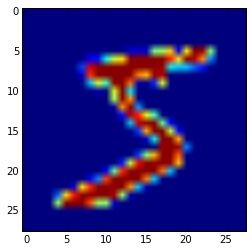

In [2]:
# Load sample of MNIST data.
filename = './MNIST_2000.csv'
X = numpy.loadtxt(filename, dtype='float32')
X, labels = X[:,1:], X[:,0].astype('uint8') # First column is label (0-9)
y = numpy.zeros((X.shape[0], 10), dtype='float32')
for i,label in enumerate(labels):
    y[i, label] = 1.0

# Show example image. 
plt.imshow(X[0,:].reshape(28,28))

# Split data into train, test.
X_train, y_train = X[:1000, :], y[:1000, :]
X_test, y_test = X[1000:, :], y[1000:, :]

# Create pylearn2 dataset objects.
from pylearn2.datasets.dense_design_matrix import DenseDesignMatrix
dataset_train = DenseDesignMatrix(X=X_train, y=y_train)
dataset_test = DenseDesignMatrix(X=X_test, y=y_test)
print dataset_train.X.shape

In [3]:
y[:10,]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

# Model
Convolutional layers have a number of additional parameters to specify, namely the kernel shapes, kernel step size, pooling shapes, and pooling step sizes. 

In [4]:
layers = []

# Layer 0
from pylearn2.models.mlp import ConvRectifiedLinear
layer = ConvRectifiedLinear(layer_name = 'h0',
                             output_channels = 16,
                             irange = .05,
                             kernel_shape = [5, 5],
                             pool_shape = [4, 4],
                             pool_stride = [2, 2],
                             max_kernel_norm = 1.9365
                            )
layers.append(layer)

# Layer 1
from pylearn2.models.mlp import ConvRectifiedLinear
layer = ConvRectifiedLinear(layer_name = 'h1',
                             output_channels = 16,
                             irange = .05,
                             kernel_shape = [5, 5],
                             pool_shape = [4, 4],
                             pool_stride = [2, 2],
                             max_kernel_norm = 1.9365
                            )
layers.append(layer)

# Layer 2
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h2', dim=100, istdev=0.05)
layers.append(layer)

# Output layer.
layer = mlp.Softmax(layer_name='y',
                    max_col_norm=1.9365,
                    n_classes=10, 
                    istdev=0.05)
layers.append(layer)

# MLP 
input_space = pylearn2.space.Conv2DSpace(shape=[28,28], num_channels=1)
model = pylearn2.models.mlp.MLP(layers, 
                                input_space=input_space,
                                seed=36)

Input shape: (28, 28)
Detector space: (24, 24)
Output space: (11, 11)
Input shape: (11, 11)
Detector space: (7, 7)
Output space: (3, 3)


# Training Algorithm


In [5]:
# Cost/objective function.
cost = pylearn2.costs.mlp.Default()      # Defaults to cross-entropy loss for softmax output.
    
# Algorithm
args = {}
args['cost'] = cost
args['learning_rate'] = 0.01
args['batch_size']    = 100
args['learning_rule'] = pylearn2.training_algorithms.learning_rule.Momentum(init_momentum = 0.5)
args['monitoring_dataset'] = {'train':dataset_train, 'test':dataset_test}
args['termination_criterion'] = pylearn2.termination_criteria.EpochCounter(max_epochs=40)
args['update_callbacks'] = pylearn2.training_algorithms.sgd.ExponentialDecay(
                                    decay_factor = 1.002, # Decreases every batch. 
                                    min_lr=.000001
                                    )
algorithm = pylearn2.training_algorithms.sgd.SGD(**args)

# Extensions 
extensions = [pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
                start=0,
                saturate = 10,
                final_momentum = 0.99)]

# Train object.
filename_model = './model_mnist_conv.pkl'
train = pylearn2.train.Train(dataset=dataset_train,
                             model=model,
                             algorithm=algorithm,
                             extensions=extensions,
                             save_path=filename_model,
                             save_freq=5)

pylearn2/train.py:85: UserWarning: dataset has no yaml src, model won't know what data it was trained on
  "data it was trained on")


# Train model

In [6]:
# Run training loop.
train.main_loop()


Parameter and initial learning rate summary:
	h0_W: 0.00999999977648
	h0_b: 0.00999999977648
	h1_W: 0.00999999977648
	h1_b: 0.00999999977648
	h2_W: 0.00999999977648
	h2_b: 0.00999999977648
	softmax_b: 0.00999999977648
	softmax_W: 0.00999999977648
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 13.783112 seconds
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 0.758814 seconds
Monitored channels: 
	learning_rate
	momentum
	test_h0_kernel_norms_max
	test_h0_kernel_norms_mean
	test_h0_kernel_norms_min
	test_h0_max_x_max_u
	test_h0_max_x_mean_u
	test_h0_max_x_min_u
	test_h0_mean_x_max_u
	test_h0_mean_x_mean_u
	test_h0_mean_x_min_u
	test_h0_min_x_max_u
	test_h0_min_x_mean_u
	test_h0_min_x_min_u
	test_h0_range_x_max_u
	test_h0_range_x_mean_u
	test_h0_range_x_min_u
	test_h1_kernel_norms_max
	test_h1_kernel_norms_mean
	test_h1_kernel_norms_min
	test_h1_max_x_max_u
	test_h1_max_x_mean_u
	test_h1_max_x_min_u
	test_h1_mean_x_max_u
	test_h1_mean_x_m

pylearn2/monitor.py:572: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 0.417333 seconds
Monitoring step:
	Epochs seen: 6
	Batches seen: 60
	Examples seen: 6000
	learning_rate: 0.00887026730925
	momentum: 0.794000029564
	test_h0_kernel_norms_max: 0.164576023817
	test_h0_kernel_norms_mean: 0.143494471908
	test_h0_kernel_norms_min: 0.117333166301
	test_h0_max_x_max_u: 0.292497724295
	test_h0_max_x_mean_u: 0.130839422345
	test_h0_max_x_min_u: 8.93290962267e-06
	test_h0_mean_x_max_u: 0.193616136909
	test_h0_mean_x_mean_u: 0.0473460331559
	test_h0_mean_x_min_u: 9.82307255981e-07
	test_h0_min_x_max_u: 0.0868440717459
	test_h0_min_x_mean_u: 0.00132079143077
	test_h0_min_x_min_u: 0.0
	test_h0_range_x_max_u: 0.289357364178
	test_h0_range_x_mean_u: 0.12951862812
	test_h0_range_x_min_u: 8.93290962267e-06
	test_h1_kernel_norms_max: 0.587842404842
	test_h1_kernel_norms_mean: 0.571449935436
	test_h1_kernel_norms_min: 0.549464285374
	test_h1_max_x_max_u: 0.208895280957
	test_h1_max_x_mean_u: 0.0762156918645
	test_h1_max_x_min_u: 0.0
	test_h1_mean_x_max_u

In [7]:
# Load saved model.
model = pickle.load(open(filename_model, 'r'))

# Print objective function after training.
channels = model.monitor.channels
print 'Train error = %f' % channels['train_y_misclass'].val_record[-1]
print 'Valid error = %f' % channels['test_y_misclass'].val_record[-1]

Train error = 0.022000
Valid error = 0.114000


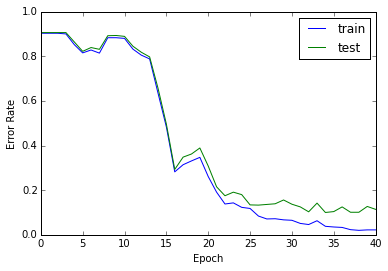

In [8]:
# Plot objective function.
plt.plot(channels['train_y_misclass'].val_record, label='train')
plt.plot(channels['test_y_misclass'].val_record, label='test')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()